In [ ]:
%matplotlib inline

# Matrix Multiplication from foundations

Assumed foundations are 
- python
- matplotlib
- python standard library
- jupyter notebooks and nbdev

In [ ]:
from nbdev.showdoc import show_doc
from fastcore.all import *

In [ ]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get Data

In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz=path_data/'mnist.pkl.gz'

In [ ]:
from urllib.request import urlretrieve

In [ ]:
# show_doc(urlretrieve)

In [ ]:
if not path_gz.exists(): urlretrieve(MNIST_URL, filename=path_gz)

In [ ]:
!ls -l data

total 16660
-rw-r--r-- 1 msivanes msivanes 17051982 Oct 19 15:12 mnist.pkl.gz


In [ ]:
# show_doc(gzip.open)
# show_doc(pickle.load)

In [ ]:
with gzip.open(path_gz, 'rb') as f: o = pickle.load(f, encoding='latin-1')

In [ ]:
len(o), len(o[0]), len(o[1]), len(o[2])

(3, 2, 2, 2)

In [ ]:
((x_train, y_train), (x_valid, y_valid), _) = o
len(x_train), len(y_train), len(x_valid), len(y_valid)

(50000, 50000, 10000, 10000)

In [ ]:
lst1 = list(x_train[0]); len(lst1)

784

In [ ]:
vals=lst1[200:210];vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

**yield** keyword will convert an expression specified along with it to a generator object and return it to the caller. Hence, to get the values stored inside the generator object, iterate over it.

In [ ]:
# Get the values in chunks using generator
def chunks(x, sz): 
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [ ]:
a=range(10);z=[]
for x in chunks(a, 4):
    z.append(list(x))
test_eq(z, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]])

list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

<matplotlib.image.AxesImage>

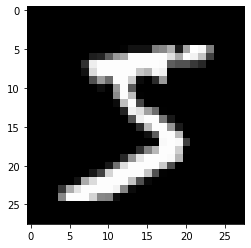

In [ ]:
mpl.rcParams['image.cmap']='gray'
plt.imshow(list(chunks(lst1, 28)))

`itertools.islice` - makes an iterator and returns the selected items from the iterable. Grabs the first n things from the iterable and if we try to grab more, raises a `StopIteration`

The functionality of chunks can be replicated using `itertools.islice`

In [ ]:
from itertools import islice

In [ ]:
it = iter(vals)
islice(it, 5)

<itertools.islice>

In [ ]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [ ]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [ ]:
list(islice(it, 5))

[]

In [ ]:
# the callable is called until the iterator returns the sentinel 
# ie empty list
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

<matplotlib.image.AxesImage>

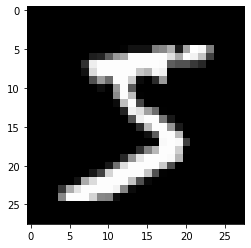

In [ ]:
plt.imshow(img)

## Matrix and tensor

In [ ]:
img[20][15]

0.98828125

We want to instead access pixels in the form of x[i, j] rather than x[i][j]. We are going to implement the magic function `__getitem__` to return the value of object at certain index. Refer [Python Object Model](http://joeyhejna.com/notes/programming/python/1objectmodel/#sources-and-further-reading)

In [ ]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [ ]:
vars(Matrix) # lists all the attributes in an objects `__dict__`

mappingproxy({'__module__': '__main__',
              '__init__': <function __main__.Matrix.__init__(self, xs)>,
              '__getitem__': <function __main__.Matrix.__getitem__(self, idxs)>,
              '__dict__': <attribute '__dict__' of 'Matrix' objects>,
              '__weakref__': <attribute '__weakref__' of 'Matrix' objects>,
              '__doc__': None})

In [ ]:
test_eq(img[20][15], 0.98828125)

m = Matrix(img)
test_eq(m[20, 15], 0.98828125)

In [ ]:
# Both are equivalent
# getattr(m, 'xs')
# m.xs

[Tensor](https://pytorch.org/docs/stable/tensors.html) - A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

In [ ]:
import torch
from torch import tensor

In [ ]:
tensor([1, 2, 3])

tensor([1, 2, 3])

In [ ]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))

In [ ]:
test_eq(x_train.shape, torch.Size([50000, 784]))
test_eq(x_train.type(), 'torch.FloatTensor')

In [ ]:
imgs = x_train.reshape((-1, 28, 28))
test_eq(imgs.shape, torch.Size([50000, 28, 28]))

<matplotlib.image.AxesImage>

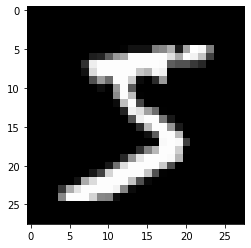

In [ ]:
plt.imshow(imgs[0])

In [ ]:
imgs[0, 20, 15]

tensor(0.9883)

In [ ]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [ ]:
test_eq(min(y_train), tensor(0))
test_eq(max(y_train), tensor(9))

test_eq(y_train.min(), tensor(0))
test_eq(y_train.max(), tensor(9))

## Random numbers

[Wichmann Hill algorithm](https://en.wikipedia.org/wiki/Wichmann%E2%80%93Hill) used before Python 2.3

In [ ]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [ ]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [ ]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [ ]:
rand(), rand(), rand()

(0.7920889799553945, 0.06912886811267205, 0.9559050644103264)

In [ ]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.840065633394744
In child: 0.840065633394744


In [ ]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.1268])
In child: tensor([0.1268])


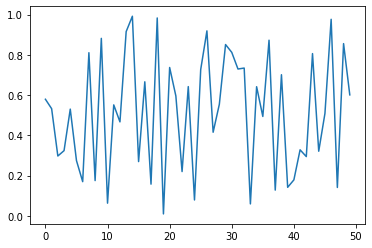

In [ ]:
plt.plot([rand() for _ in range(50)]);

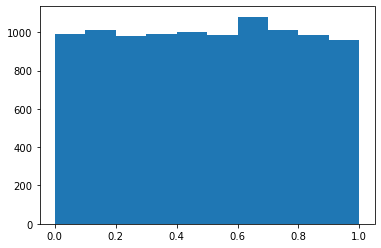

In [ ]:
plt.hist([rand() for _ in range(10000)]);

In [ ]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.47 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 torch.randn(784, 10)

The slowest run took 4.46 times longer than the fastest. This could mean that an intermediate result is being cached.
488 µs ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
